 # Analyse de Clustering Client - Épicerie du Quartier



 **Objectif** : Analyser les données clients d'une épicerie pour identifier des groupes de clients aux comportements similaires et proposer des stratégies marketing adaptées.



 **Plan de travail** :

 - a. Exploration et analyse des données

 - b. Nettoyage et pré-traitement des données

 - c. Réduction de dimension (sélection de features + analyse factorielle)

 - d. Application de 3 algorithmes de classification non supervisée

 - e. Comparaison et évaluation des modèles

 - f. Profiling des groupes de clients

 - g. Conclusion

 ## Imports et configuration

In [11]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Imports terminés - Prêt pour l'analyse !")

✅ Imports terminés - Prêt pour l'analyse !


 ## a. EXPLORATION ET ANALYSE DES DONNÉES

In [12]:
# # Chargement des données
# df = pd.read_csv('../data/marketing_campaign.csv', sep='\t')
file_path = "marketing_campaign.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "imakash3011/customer-personality-analysis",
    file_path,
)

import io

csv_buffer = io.StringIO(df.to_csv(index=False))
df_corrected = pd.read_csv(csv_buffer, sep='\t')

print(df_corrected.head())

df_corrected.to_csv('../data/marketing_campaign.csv', index=False)
df = df_corrected

print("📊 APERÇU GÉNÉRAL DU DATASET")
print("=" * 50)
print(f"Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"Mémoire utilisée : {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Informations sur les types de données
print("\n📋 TYPES DE DONNÉES")
print("-" * 30)
print(df.dtypes.value_counts())

# Premiers aperçus
print("\n🔍 APERÇU DES DONNÉES")
print("-" * 30)
df.head()


     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsP

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [13]:
# Analyse des valeurs manquantes
print("❓ ANALYSE DES VALEURS MANQUANTES")
print("=" * 40)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Colonnes': missing_data.index,
    'Valeurs_manquantes': missing_data.values,
    'Pourcentage': missing_percent.values
}).sort_values('Valeurs_manquantes', ascending=False)

print(missing_df[missing_df['Valeurs_manquantes'] > 0])

# Traitement des valeurs manquantes dans Income
if df['Income'].isnull().sum() > 0:
    print(f"\n⚠️ {df['Income'].isnull().sum()} valeurs manquantes dans Income")
    print("Remplacement par la médiane...")
    df['Income'].fillna(df['Income'].median(), inplace=True)


❓ ANALYSE DES VALEURS MANQUANTES
  Colonnes  Valeurs_manquantes  Pourcentage
4   Income                  24     1.071429

⚠️ 24 valeurs manquantes dans Income
Remplacement par la médiane...


In [14]:
# Statistiques descriptives
print("📈 STATISTIQUES DESCRIPTIVES - VARIABLES NUMÉRIQUES")
print("=" * 60)
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe().round(2))


📈 STATISTIQUES DESCRIPTIVES - VARIABLES NUMÉRIQUES
             ID  Year_Birth     Income  Kidhome  Teenhome  Recency  MntWines  \
count   2240.00     2240.00    2240.00  2240.00   2240.00  2240.00   2240.00   
mean    5592.16     1968.81   52237.98     0.44      0.51    49.11    303.94   
std     3246.66       11.98   25037.96     0.54      0.54    28.96    336.60   
min        0.00     1893.00    1730.00     0.00      0.00     0.00      0.00   
25%     2828.25     1959.00   35538.75     0.00      0.00    24.00     23.75   
50%     5458.50     1970.00   51381.50     0.00      0.00    49.00    173.50   
75%     8427.75     1977.00   68289.75     1.00      1.00    74.00    504.25   
max    11191.00     1996.00  666666.00     2.00      2.00    99.00   1493.00   

       MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
count    2240.00          2240.00          2240.00           2240.00   
mean       26.30           166.95            37.53             27.06   
std        3

In [15]:
# Analyse des variables catégorielles
print("🏷️ ANALYSE DES VARIABLES CATÉGORIELLES")
print("=" * 45)
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(f"\n📊 {col}:")
    print(df[col].value_counts())
    print(f"Modalités uniques : {df[col].nunique()}")


🏷️ ANALYSE DES VARIABLES CATÉGORIELLES

📊 Education:
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64
Modalités uniques : 5

📊 Marital_Status:
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64
Modalités uniques : 8

📊 Dt_Customer:
Dt_Customer
31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
25-05-2013     1
14-04-2013     1
09-01-2014     1
Name: count, Length: 663, dtype: int64
Modalités uniques : 663


📊 VISUALISATION DES DISTRIBUTIONS


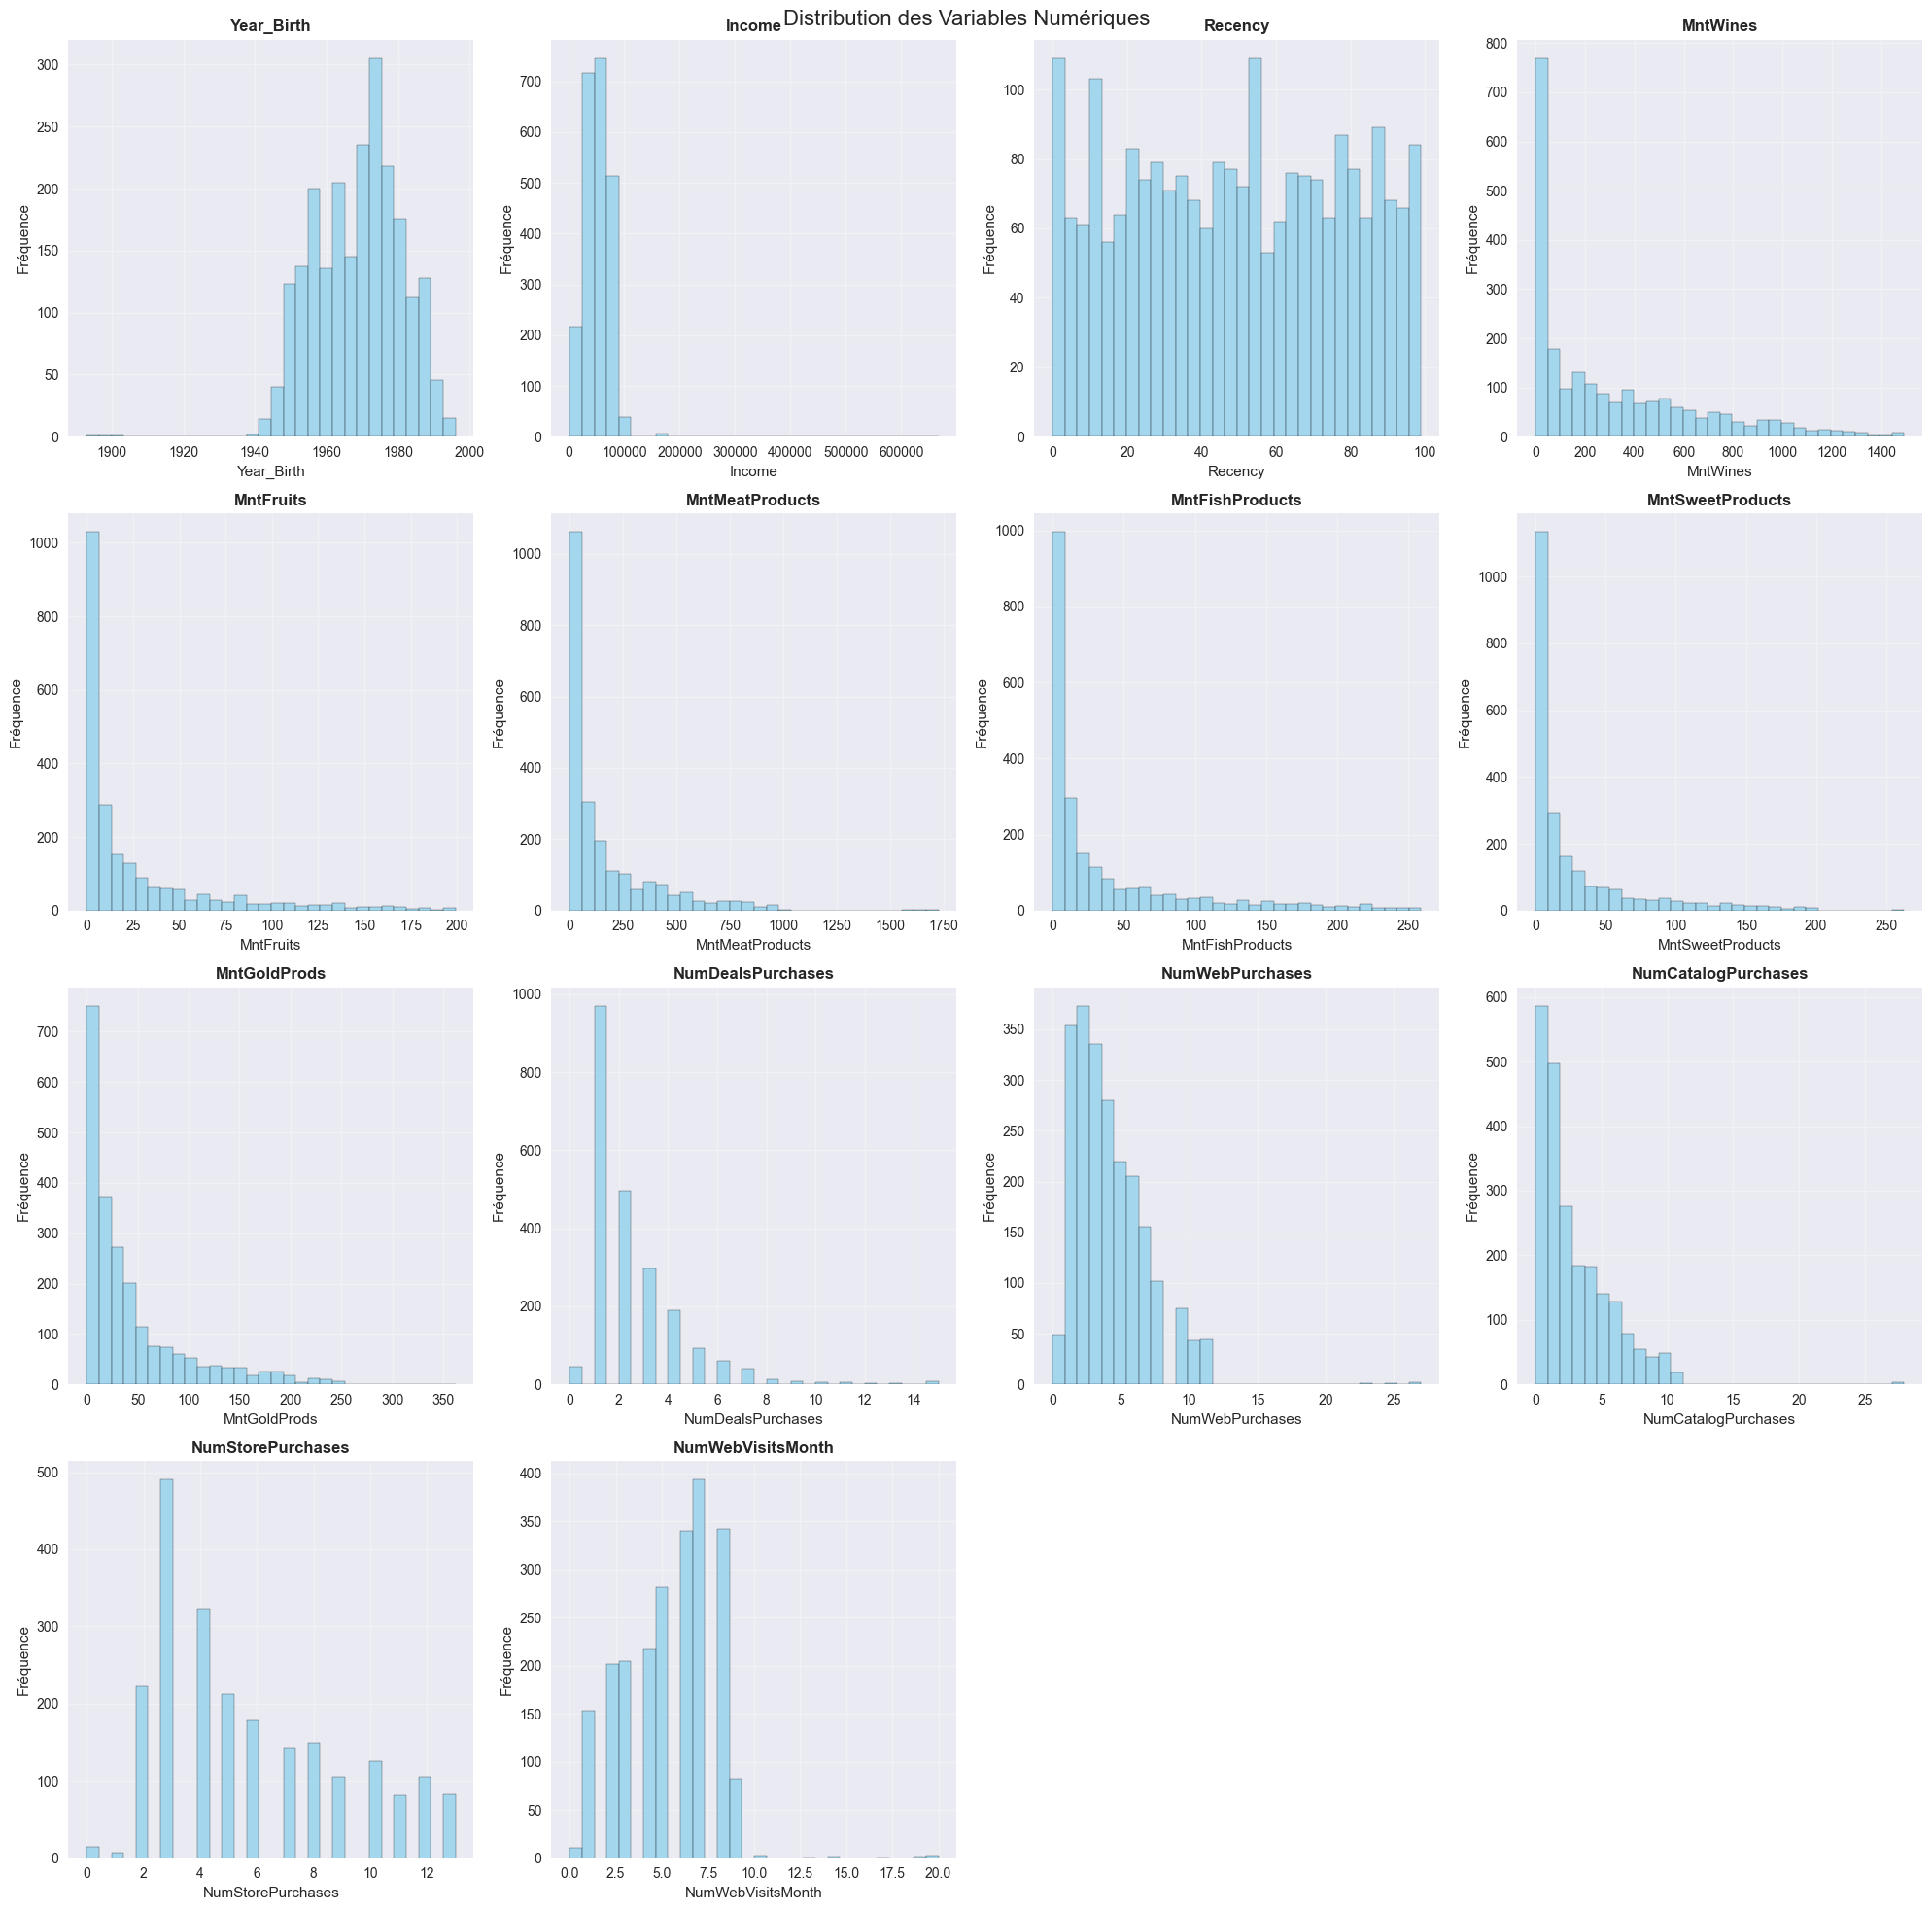

In [16]:
# Visualisation des distributions
print("📊 VISUALISATION DES DISTRIBUTIONS")
print("=" * 40)

# Variables numériques continues
numeric_vars = ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits',
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

n_vars = len(numeric_vars)
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Distribution des Variables Numériques', fontsize=16, y=0.98)

for i, var in enumerate(numeric_vars):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    ax.hist(df[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'{var}', fontweight='bold')
    ax.set_xlabel(var)
    ax.set_ylabel('Fréquence')
    ax.grid(True, alpha=0.3)

# Masquer les subplots inutilisés
for i in range(n_vars, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.set_visible(False)

plt.tight_layout()
plt.show()


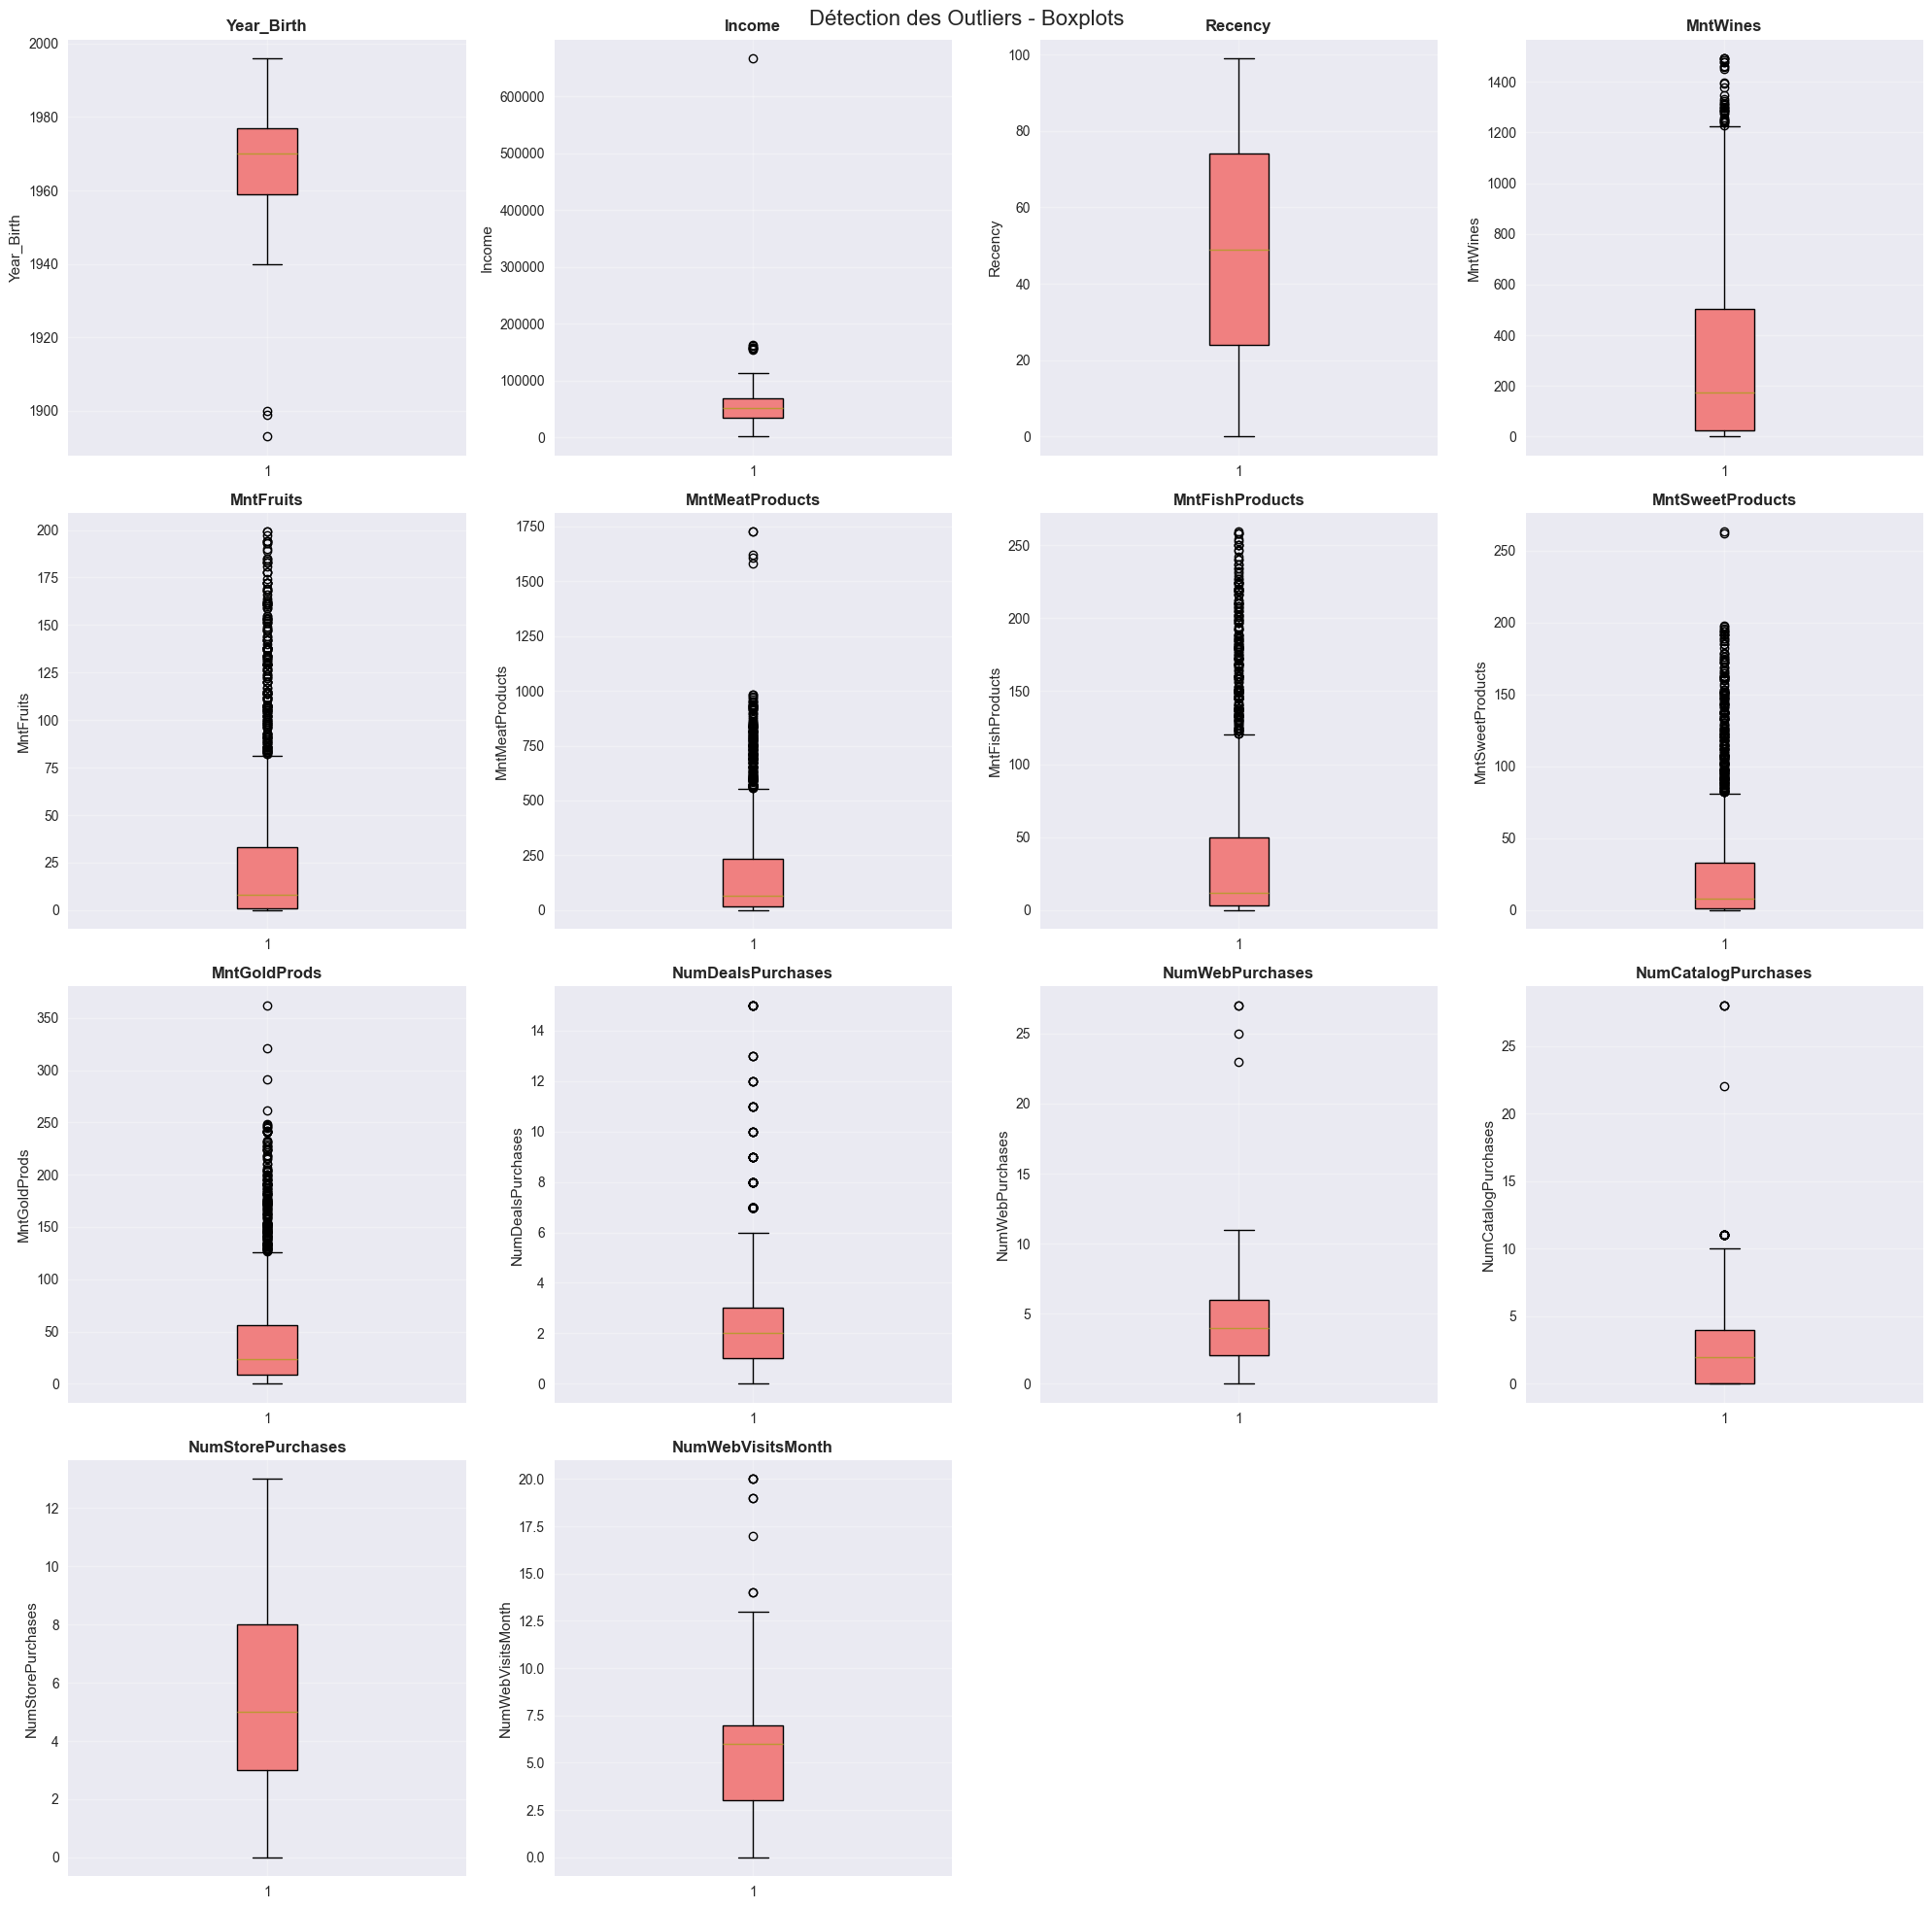

In [17]:
# Détection des outliers avec boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Détection des Outliers - Boxplots', fontsize=16, y=0.98)

for i, var in enumerate(numeric_vars):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    bp = ax.boxplot(df[var], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightcoral')
    ax.set_title(f'{var}', fontweight='bold')
    ax.set_ylabel(var)
    ax.grid(True, alpha=0.3)

# Masquer les subplots inutilisés
for i in range(n_vars, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.set_visible(False)

plt.tight_layout()
plt.show()


🔗 MATRICE DE CORRÉLATION


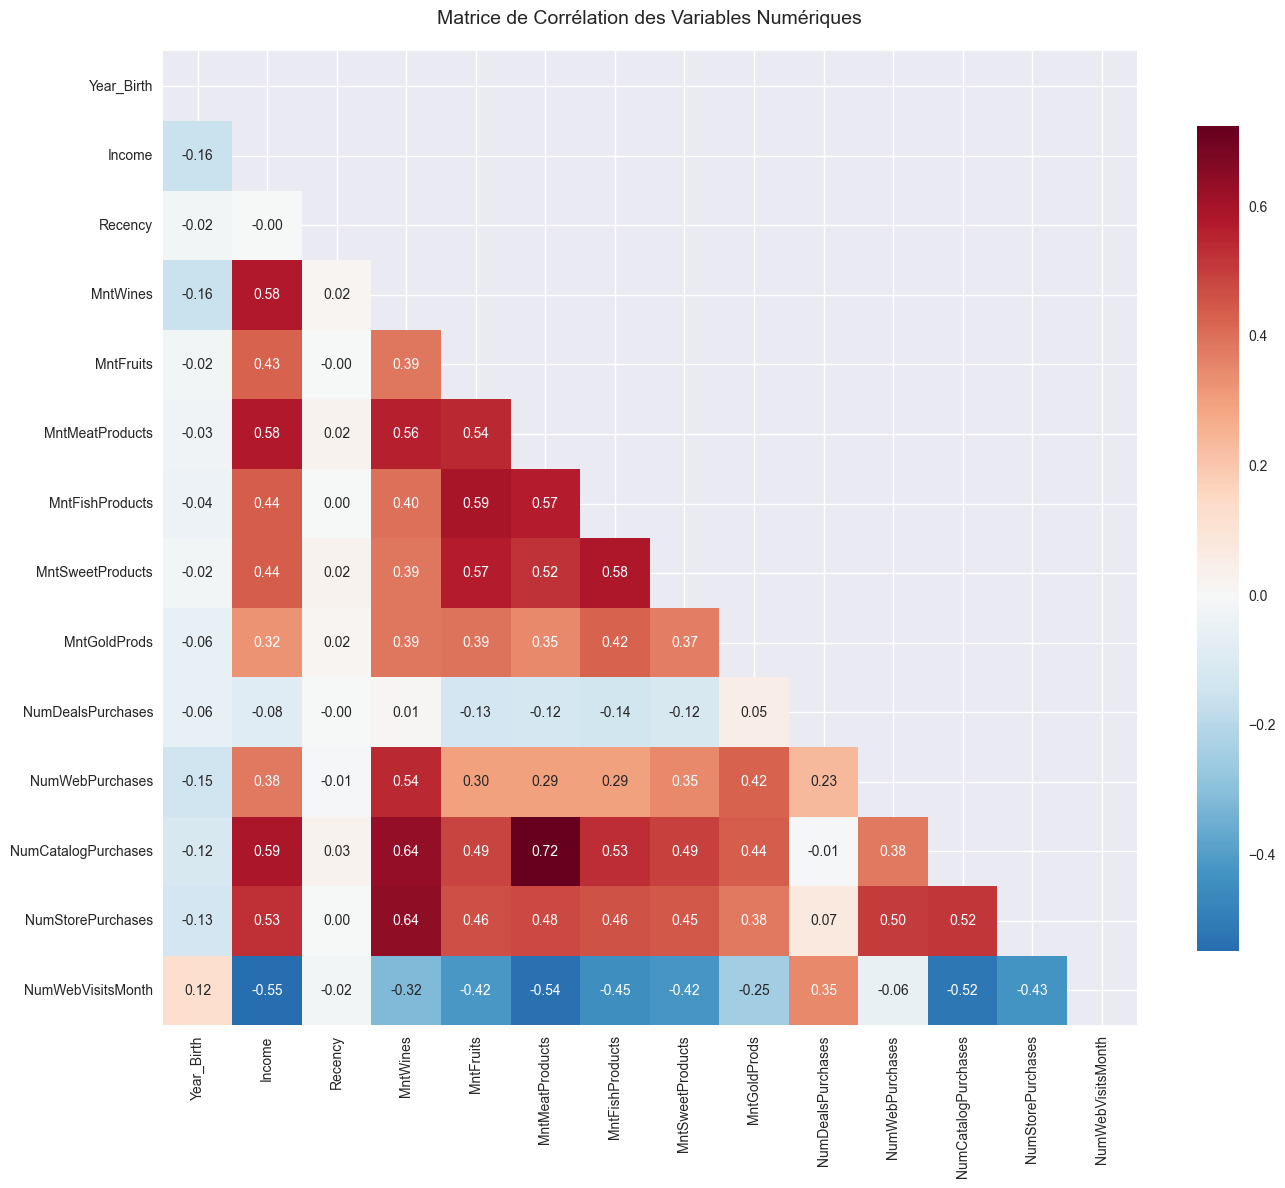


🔍 CORRÉLATIONS FORTES (|r| > 0.7):
• MntMeatProducts ↔ NumCatalogPurchases : 0.724


In [18]:
# Matrice de corrélation
print("🔗 MATRICE DE CORRÉLATION")
print("=" * 30)

correlation_matrix = df[numeric_vars].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
            center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation des Variables Numériques', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Corrélations fortes (>0.7 ou <-0.7)
print("\n🔍 CORRÉLATIONS FORTES (|r| > 0.7):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                  correlation_matrix.columns[j], 
                                  corr_val))

for var1, var2, corr in high_corr_pairs:
    print(f"• {var1} ↔ {var2} : {corr:.3f}")


 ## b. NETTOYAGE ET PRÉ-TRAITEMENT DES DONNÉES

In [19]:
print("🧹 NETTOYAGE ET PRÉ-TRAITEMENT")
print("=" * 40)

# Sauvegarde du dataset original
df_original = df.copy()
print(f"Dataset original sauvegardé : {df_original.shape}")

# Création de variables métier
def create_business_features(df):
    """Création de features métier pertinentes"""
    df = df.copy()
    
    # Âge du client
    df['Age'] = 2024 - df['Year_Birth']
    
    # Total des dépenses par catégorie
    expense_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
    df['Total_Spent'] = df[expense_cols].sum(axis=1)
    
    # Total des achats
    purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 
                    'NumStorePurchases', 'NumDealsPurchases']
    df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
    
    # Panier moyen
    df['Avg_Order_Value'] = df['Total_Spent'] / (df['Total_Purchases'] + 1)
    
    # Nombre total d'enfants
    df['Total_Children'] = df['Kidhome'] + df['Teenhome']
    
    # Acceptation campagnes marketing
    campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
                    'AcceptedCmp4', 'AcceptedCmp5', 'Response']
    df['Total_Campaigns_Accepted'] = df[campaign_cols].sum(axis=1)
    
    # Ancienneté client
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
    reference_date = df['Dt_Customer'].max()
    df['Customer_Tenure_Days'] = (reference_date - df['Dt_Customer']).dt.days
    
    return df

# Application de la fonction
df = create_business_features(df)

new_features = ['Age', 'Total_Spent', 'Total_Purchases', 'Avg_Order_Value', 
               'Total_Children', 'Total_Campaigns_Accepted', 'Customer_Tenure_Days']

print("✅ Nouvelles features créées:")
for feature in new_features:
    print(f"• {feature}")


🧹 NETTOYAGE ET PRÉ-TRAITEMENT
Dataset original sauvegardé : (2240, 29)
✅ Nouvelles features créées:
• Age
• Total_Spent
• Total_Purchases
• Avg_Order_Value
• Total_Children
• Total_Campaigns_Accepted
• Customer_Tenure_Days


In [20]:
# Nettoyage des outliers avec des règles métier
print("\n🎯 NETTOYAGE DES OUTLIERS")
print("-" * 30)

def clean_outliers(df):
    """Nettoyage des outliers selon des règles métier"""
    df_clean = df.copy()
    initial_size = len(df_clean)
    
    # Règles métier pour les outliers
    filters = {
        'Age réaliste': (df_clean['Age'] >= 18) & (df_clean['Age'] <= 100),
        'Revenu cohérent': df_clean['Income'] < 200000,
        'Dépenses réalistes': df_clean['Total_Spent'] < 5000,
        'Achats cohérents': df_clean['Total_Purchases'] < 50,
        'Visites web réalistes': df_clean['NumWebVisitsMonth'] < 20
    }
    
    for rule_name, condition in filters.items():
        removed = (~condition).sum()
        if removed > 0:
            print(f"• {rule_name}: {removed} lignes supprimées")
        df_clean = df_clean[condition]
    
    print(f"\nDataset après nettoyage: {len(df_clean)} lignes (-{initial_size - len(df_clean)})")
    return df_clean

df_clean = clean_outliers(df)



🎯 NETTOYAGE DES OUTLIERS
------------------------------
• Age réaliste: 3 lignes supprimées
• Revenu cohérent: 1 lignes supprimées
• Visites web réalistes: 3 lignes supprimées

Dataset après nettoyage: 2233 lignes (-7)


In [21]:
# Détection d'outliers multivariés avec Isolation Forest
print("\n🌲 DÉTECTION D'OUTLIERS MULTIVARIÉS (ISOLATION FOREST)")
print("-" * 55)

# Sélection des variables numériques pour l'Isolation Forest
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
numeric_features = [col for col in numeric_features if col not in ['ID']]

# Application d'Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_clean[numeric_features])

print(f"Outliers détectés: {(outlier_labels == -1).sum()}")
print(f"Points normaux: {(outlier_labels == 1).sum()}")

# Suppression des outliers
df_clean = df_clean[outlier_labels == 1]
print(f"Dataset final: {len(df_clean)} lignes")



🌲 DÉTECTION D'OUTLIERS MULTIVARIÉS (ISOLATION FOREST)
-------------------------------------------------------
Outliers détectés: 112
Points normaux: 2121
Dataset final: 2121 lignes


In [22]:
# Encodage des variables catégorielles
print("\n🏷️ ENCODAGE DES VARIABLES CATÉGORIELLES")
print("-" * 45)

# Encodage de l'éducation (ordinal)
education_mapping = {
    'Basic': 1,
    '2n Cycle': 2, 
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}

# Encodage du statut marital (binaire)
marital_mapping = {
    'Single': 0, 'Divorced': 0, 'Widow': 0, 'Alone': 0, 'Absurd': 0, 'YOLO': 0,
    'Together': 1, 'Married': 1
}

df_clean['Education_Encoded'] = df_clean['Education'].map(education_mapping)
df_clean['Marital_Status_Encoded'] = df_clean['Marital_Status'].map(marital_mapping)

print("✅ Variables catégorielles encodées:")
print(f"• Education: {dict(df_clean['Education_Encoded'].value_counts().sort_index())}")
print(f"• Marital Status: {dict(df_clean['Marital_Status_Encoded'].value_counts().sort_index())}")



🏷️ ENCODAGE DES VARIABLES CATÉGORIELLES
---------------------------------------------
✅ Variables catégorielles encodées:
• Education: {1: 54, 2: 189, 3: 1063, 4: 353, 5: 462}
• Marital Status: {0: 753, 1: 1368}


In [23]:
# Suppression des variables non pertinentes
print("\n🗑️ SUPPRESSION DES VARIABLES NON PERTINENTES")
print("-" * 50)

columns_to_drop = ['ID', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'Dt_Customer', 
                  'Education', 'Marital_Status']

# Vérifier quelles colonnes existent réellement
existing_cols_to_drop = [col for col in columns_to_drop if col in df_clean.columns]
df_clean = df_clean.drop(columns=existing_cols_to_drop)

print(f"✅ Colonnes supprimées: {existing_cols_to_drop}")
print(f"Dataset final: {df_clean.shape}")



🗑️ SUPPRESSION DES VARIABLES NON PERTINENTES
--------------------------------------------------
✅ Colonnes supprimées: ['ID', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'Dt_Customer', 'Education', 'Marital_Status']
Dataset final: (2121, 31)


In [24]:
# Aperçu final des données nettoyées
print("\n📊 APERÇU FINAL DES DONNÉES NETTOYÉES")
print("=" * 45)
print(f"Dimensions finales: {df_clean.shape}")
print(f"Variables numériques: {len(df_clean.select_dtypes(include=[np.number]).columns)}")
print("\nPremières lignes:")
print(df_clean.head())



📊 APERÇU FINAL DES DONNÉES NETTOYÉES
Dimensions finales: (2121, 31)
Variables numériques: 31

Premières lignes:
    Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  MntMeatProducts  \
0  58138.0        0         0       58       635         88              546   
1  46344.0        1         1       38        11          1                6   
2  71613.0        0         0       26       426         49              127   
3  26646.0        1         0       26        11          4               20   
4  58293.0        1         0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0              172                88            88                  3   
1                2                 1             6                  2   
2              111                21            42                  1   
3               10                 3             5                  2   
4               46                27     

 ## c. RÉDUCTION DE DIMENSION

 ### c.1 Sélection de Features

In [ ]:
print("🎯 SÉLECTION DE FEATURES")
print("=" * 30)

# Préparation des données pour la sélection
X = df_clean.select_dtypes(include=[np.number])
print(f"Variables disponibles pour la sélection: {X.shape[1]}")

# 1. Suppression des features à variance faible
variance_selector = VarianceThreshold(threshold=0.01)
X_variance_filtered = variance_selector.fit_transform(X)
selected_features_variance = X.columns[variance_selector.get_support()]

print(f"\n📊 Après filtrage par variance:")
print(f"• Features conservées: {len(selected_features_variance)}")
print(f"• Features supprimées: {X.shape[1] - len(selected_features_variance)}")
#  ajouter colonne supprimées

# 2. Sélection par importance statistique
# Créer une variable cible temporaire pour la sélection (clustering k-means préliminaire)
kmeans_temp = KMeans(n_clusters=3, random_state=42)
y_temp = kmeans_temp.fit_predict(StandardScaler().fit_transform(X))

# Sélection des k meilleures features
k_best_selector = SelectKBest(score_func=f_classif, k=15)
X_selected = k_best_selector.fit_transform(X, y_temp)
selected_features_kbest = X.columns[k_best_selector.get_support()]

print(f"\n🏆 Top 15 features sélectionnées:")
feature_scores = k_best_selector.scores_
feature_importance = pd.DataFrame({
    'Feature': selected_features_kbest,
    'Score': feature_scores[k_best_selector.get_support()]
}).sort_values('Score', ascending=False)

print(feature_importance.round(2))

# Features finales sélectionnées
selected_features = selected_features_kbest.tolist()
X_selected_df = df_clean[selected_features]


🎯 SÉLECTION DE FEATURES
Variables disponibles pour la sélection: 31

📊 Après filtrage par variance:
• Features conservées: 29
• Features supprimées: 2

🏆 Top 15 features sélectionnées:
                Feature    Score
11             Complain      inf
12          Total_Spent  3110.56
14      Avg_Order_Value  1858.22
2              MntWines  1485.24
9   NumCatalogPurchases  1445.22
13      Total_Purchases  1380.40
0                Income  1220.28
10    NumStorePurchases  1178.40
4       MntMeatProducts  1007.98
5       MntFishProducts   595.00
6      MntSweetProducts   560.36
3             MntFruits   539.59
1               Kidhome   537.05
8       NumWebPurchases   439.38
7          MntGoldProds   380.08


In [26]:
print("\n📋 FEATURES FINALES SÉLECTIONNÉES")
print("-" * 40)
print(f"Nombre total: {len(selected_features)}")
print("Liste des features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")



📋 FEATURES FINALES SÉLECTIONNÉES
----------------------------------------
Nombre total: 15
Liste des features:
 1. Income
 2. Kidhome
 3. MntWines
 4. MntFruits
 5. MntMeatProducts
 6. MntFishProducts
 7. MntSweetProducts
 8. MntGoldProds
 9. NumWebPurchases
10. NumCatalogPurchases
11. NumStorePurchases
12. Complain
13. Total_Spent
14. Total_Purchases
15. Avg_Order_Value


 ### c.2 Analyse en Composantes Principales (PCA)

🔍 ANALYSE EN COMPOSANTES PRINCIPALES (PCA)
📊 Analyse de la variance:
• Composantes pour 85% de variance: 7
• Composantes pour 90% de variance: 8
• Composantes pour 95% de variance: 10


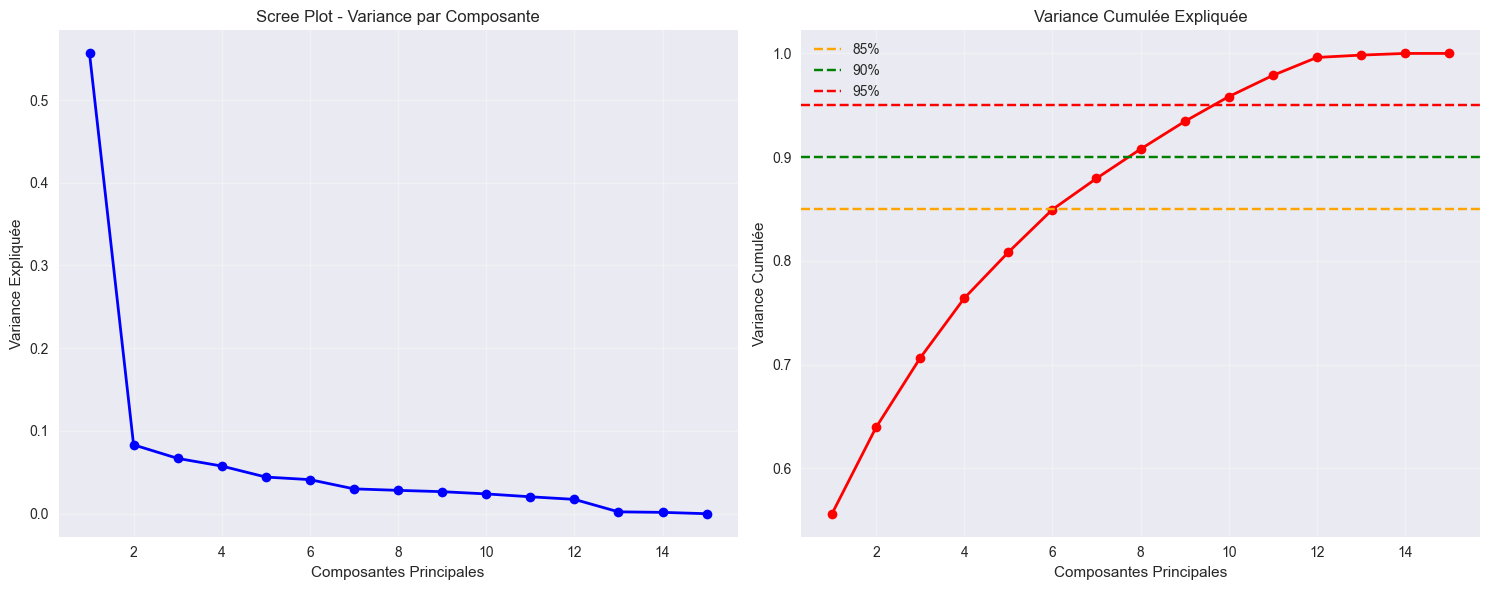

In [27]:
print("🔍 ANALYSE EN COMPOSANTES PRINCIPALES (PCA)")
print("=" * 50)

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected_df)

# PCA complète pour analyser la variance
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Analyse de la variance expliquée
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print(f"📊 Analyse de la variance:")
print(f"• Composantes pour 85% de variance: {n_components_85}")
print(f"• Composantes pour 90% de variance: {n_components_90}")
print(f"• Composantes pour 95% de variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

# Visualisation de la variance expliquée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scree plot
ax1.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'bo-', linewidth=2)
ax1.set_xlabel('Composantes Principales')
ax1.set_ylabel('Variance Expliquée')
ax1.set_title('Scree Plot - Variance par Composante')
ax1.grid(True, alpha=0.3)

# Variance cumulée
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', linewidth=2)
ax2.axhline(y=0.85, color='orange', linestyle='--', label='85%')
ax2.axhline(y=0.90, color='green', linestyle='--', label='90%')
ax2.axhline(y=0.95, color='red', linestyle='--', label='95%')
ax2.set_xlabel('Composantes Principales')
ax2.set_ylabel('Variance Cumulée')
ax2.set_title('Variance Cumulée Expliquée')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



✅ PCA FINALE
• Composantes conservées: 8
• Variance totale expliquée: 0.908
• Dimensions réduites: 15 → 8

📊 CONTRIBUTIONS DES VARIABLES AUX COMPOSANTES PRINCIPALES:
                       PC1    PC2    PC3    PC4    PC5
Income               0.287  0.009  0.003 -0.231 -0.103
Kidhome             -0.222 -0.064  0.013  0.096 -0.469
MntWines             0.285  0.279 -0.004 -0.326  0.027
MntFruits            0.232 -0.369  0.043  0.273 -0.219
MntMeatProducts      0.283 -0.252 -0.015 -0.272  0.000
MntFishProducts      0.240 -0.384  0.006  0.230 -0.047
MntSweetProducts     0.231 -0.325 -0.001  0.280 -0.304
MntGoldProds         0.204  0.041 -0.060  0.542  0.660
NumWebPurchases      0.217  0.496  0.043  0.343 -0.179
NumCatalogPurchases  0.289 -0.035 -0.004 -0.143  0.086
NumStorePurchases    0.271  0.240  0.050  0.053 -0.265
Complain            -0.013 -0.036  0.993 -0.022  0.092
Total_Spent          0.335 -0.017 -0.009 -0.172  0.034
Total_Purchases      0.295  0.367  0.044  0.167 -0.208
Avg_Orde

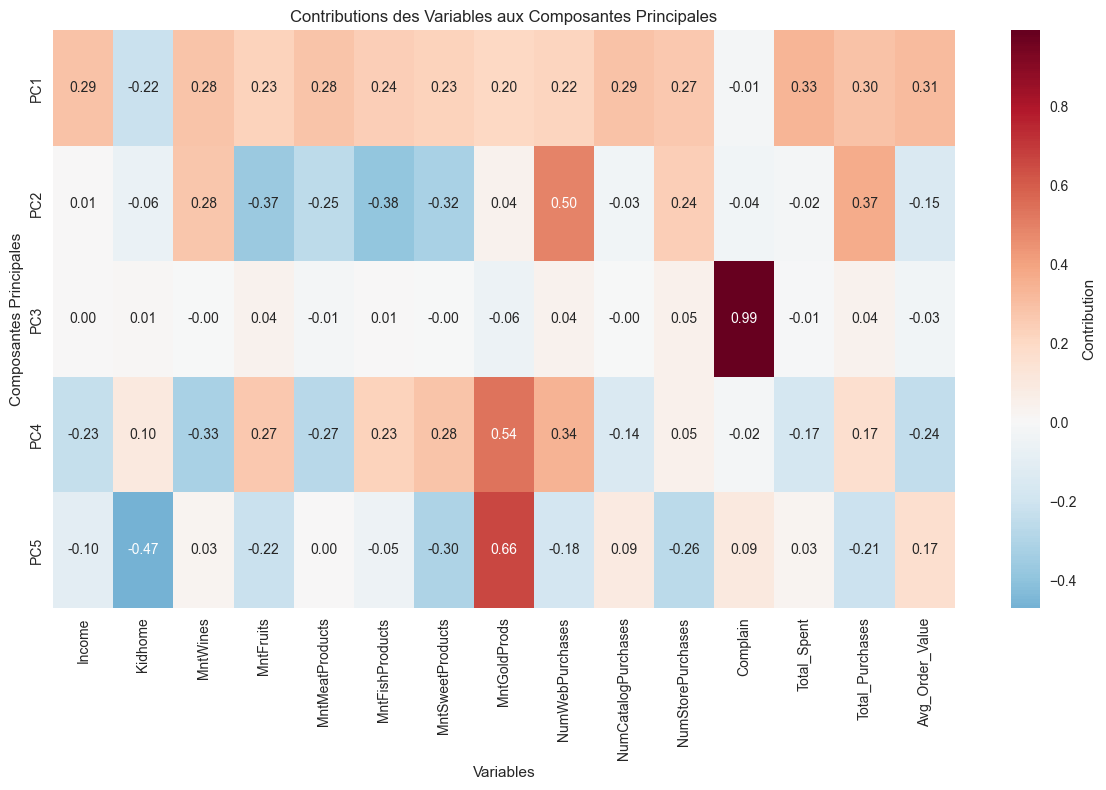

In [28]:
# PCA finale avec nombre optimal de composantes
pca_final = PCA(n_components=n_components_90)
X_pca = pca_final.fit_transform(X_scaled)

print(f"\n✅ PCA FINALE")
print(f"• Composantes conservées: {pca_final.n_components_}")
print(f"• Variance totale expliquée: {pca_final.explained_variance_ratio_.sum():.3f}")
print(f"• Dimensions réduites: {X_scaled.shape[1]} → {X_pca.shape[1]}")

# Analyse des contributions des variables aux composantes principales
components_df = pd.DataFrame(
    pca_final.components_[:5].T,  # Top 5 composantes
    columns=[f'PC{i+1}' for i in range(min(5, pca_final.n_components_))],
    index=selected_features
)

print(f"\n📊 CONTRIBUTIONS DES VARIABLES AUX COMPOSANTES PRINCIPALES:")
print(components_df.round(3))

# Visualisation des contributions
plt.figure(figsize=(12, 8))
sns.heatmap(components_df.T, annot=True, cmap='RdBu_r', center=0, 
           fmt='.2f', cbar_kws={'label': 'Contribution'})
plt.title('Contributions des Variables aux Composantes Principales')
plt.xlabel('Variables')
plt.ylabel('Composantes Principales')
plt.tight_layout()
plt.show()


 ## d. APPLICATION DE 3 ALGORITHMES DE CLASSIFICATION NON SUPERVISÉE

In [29]:
print("🤖 ALGORITHMES DE CLASSIFICATION NON SUPERVISÉE")
print("=" * 55)

# Données finales pour le clustering
X_final = X_pca  # Utilisation des composantes principales
print(f"Données pour clustering: {X_final.shape}")


🤖 ALGORITHMES DE CLASSIFICATION NON SUPERVISÉE
Données pour clustering: (2121, 8)


 ### d.1 Détermination du nombre optimal de clusters

In [30]:
print("🎯 DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS")
print("=" * 50)

def evaluate_clustering(X, max_k=10):
    """Évalue différents nombres de clusters"""
    
    metrics = {
        'k': [],
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in range(2, max_k + 1):
        # K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calcul des métriques
        metrics['k'].append(k)
        metrics['inertia'].append(kmeans.inertia_)
        metrics['silhouette'].append(silhouette_score(X, labels))
        metrics['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
        metrics['davies_bouldin'].append(davies_bouldin_score(X, labels))
    
    return pd.DataFrame(metrics)

# Évaluation
clustering_metrics = evaluate_clustering(X_final)
print("📊 Métriques d'évaluation par nombre de clusters:")
print(clustering_metrics.round(3))


🎯 DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS
📊 Métriques d'évaluation par nombre de clusters:
    k    inertia  silhouette  calinski_harabasz  davies_bouldin
0   2  14678.265       0.475           2050.359           0.900
1   3  11874.049       0.394           1516.788           1.288
2   4   9854.749       0.407           1362.412           1.053
3   5   8862.647       0.337           1194.873           1.289
4   6   8110.033       0.334           1083.367           1.366
5   7   7474.878       0.315           1008.994           1.313
6   8   7024.766       0.319            939.174           1.330
7   9   6649.220       0.321            882.691           1.368
8  10   6273.620       0.328            845.238           1.340


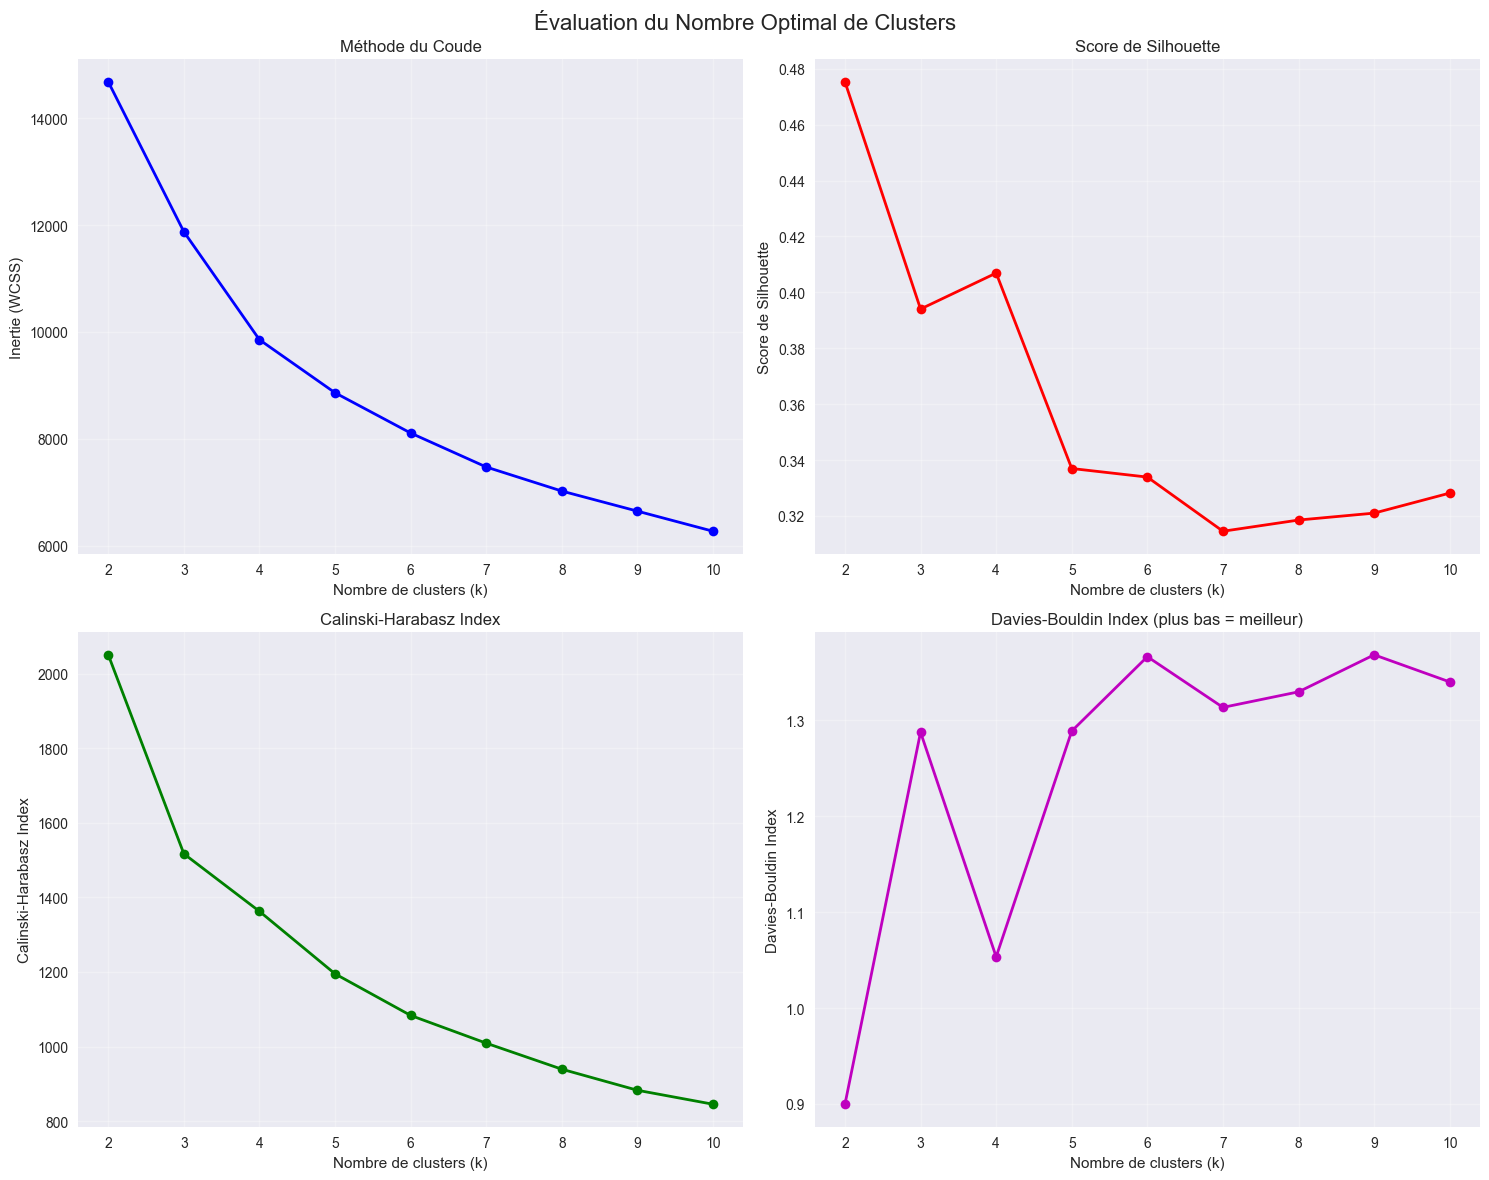


🏆 RECOMMANDATIONS POUR K:
• Meilleur k selon Silhouette: 2
• Meilleur k selon Calinski-Harabasz: 2
• Meilleur k selon Davies-Bouldin: 2

✅ K OPTIMAL CHOISI: 2


In [31]:
# Visualisation des métriques d'évaluation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Évaluation du Nombre Optimal de Clusters', fontsize=16)

# Méthode du coude (Inertia)
axes[0,0].plot(clustering_metrics['k'], clustering_metrics['inertia'], 'bo-', linewidth=2)
axes[0,0].set_xlabel('Nombre de clusters (k)')
axes[0,0].set_ylabel('Inertie (WCSS)')
axes[0,0].set_title('Méthode du Coude')
axes[0,0].grid(True, alpha=0.3)

# Score de Silhouette
axes[0,1].plot(clustering_metrics['k'], clustering_metrics['silhouette'], 'ro-', linewidth=2)
axes[0,1].set_xlabel('Nombre de clusters (k)')
axes[0,1].set_ylabel('Score de Silhouette')
axes[0,1].set_title('Score de Silhouette')
axes[0,1].grid(True, alpha=0.3)

# Calinski-Harabasz Index
axes[1,0].plot(clustering_metrics['k'], clustering_metrics['calinski_harabasz'], 'go-', linewidth=2)
axes[1,0].set_xlabel('Nombre de clusters (k)')
axes[1,0].set_ylabel('Calinski-Harabasz Index')
axes[1,0].set_title('Calinski-Harabasz Index')
axes[1,0].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[1,1].plot(clustering_metrics['k'], clustering_metrics['davies_bouldin'], 'mo-', linewidth=2)
axes[1,1].set_xlabel('Nombre de clusters (k)')
axes[1,1].set_ylabel('Davies-Bouldin Index')
axes[1,1].set_title('Davies-Bouldin Index (plus bas = meilleur)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Recommandation du nombre optimal
best_k_silhouette = clustering_metrics.loc[clustering_metrics['silhouette'].idxmax(), 'k']
best_k_calinski = clustering_metrics.loc[clustering_metrics['calinski_harabasz'].idxmax(), 'k']
best_k_davies = clustering_metrics.loc[clustering_metrics['davies_bouldin'].idxmin(), 'k']

print(f"\n🏆 RECOMMANDATIONS POUR K:")
print(f"• Meilleur k selon Silhouette: {best_k_silhouette}")
print(f"• Meilleur k selon Calinski-Harabasz: {best_k_calinski}")
print(f"• Meilleur k selon Davies-Bouldin: {best_k_davies}")

# Choix final
optimal_k = int(best_k_silhouette)  # Privilégier la silhouette
print(f"\n✅ K OPTIMAL CHOISI: {optimal_k}")


 ### d.2 Algorithme 1 : K-Means

In [32]:
print("🔵 ALGORITHME 1 : K-MEANS")
print("=" * 30)

# Application de K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_final)

# Métriques d'évaluation
metrics_kmeans = {
    'silhouette': silhouette_score(X_final, labels_kmeans),
    'calinski_harabasz': calinski_harabasz_score(X_final, labels_kmeans),
    'davies_bouldin': davies_bouldin_score(X_final, labels_kmeans),
    'inertia': kmeans.inertia_
}

print(f"📊 Métriques K-Means:")
for metric, value in metrics_kmeans.items():
    print(f"• {metric}: {value:.3f}")

# Distribution des clusters
cluster_counts = pd.Series(labels_kmeans).value_counts().sort_index()
print(f"\n📈 Distribution des clusters:")
for cluster, count in cluster_counts.items():
    percentage = (count / len(labels_kmeans)) * 100
    print(f"• Cluster {cluster}: {count} clients ({percentage:.1f}%)")


🔵 ALGORITHME 1 : K-MEANS
📊 Métriques K-Means:
• silhouette: 0.475
• calinski_harabasz: 2050.359
• davies_bouldin: 0.900
• inertia: 14678.265

📈 Distribution des clusters:
• Cluster 0: 1235 clients (58.2%)
• Cluster 1: 886 clients (41.8%)


 ### d.3 Algorithme 2 : Classification Ascendante Hiérarchique (CAH)

🔶 ALGORITHME 2 : CLASSIFICATION ASCENDANTE HIÉRARCHIQUE


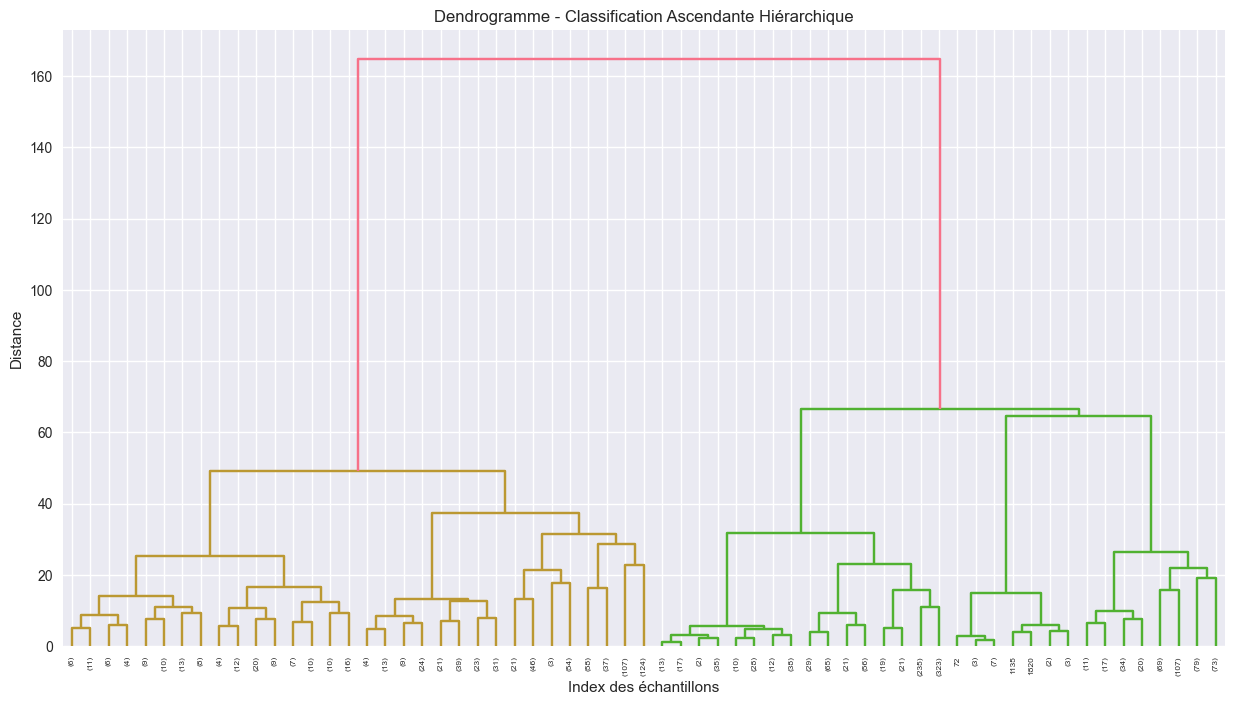

📊 Métriques CAH:


In [33]:
print("🔶 ALGORITHME 2 : CLASSIFICATION ASCENDANTE HIÉRARCHIQUE")
print("=" * 60)

# Dendrogramme pour visualiser la hiérarchie
plt.figure(figsize=(15, 8))
linkage_matrix = linkage(X_final, method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Dendrogramme - Classification Ascendante Hiérarchique')
plt.xlabel('Index des échantillons')
plt.ylabel('Distance')
plt.show()

# Application de CAH
cah = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_cah = cah.fit_predict(X_final)

# Métriques d'évaluation
metrics_cah = {
    'silhouette': silhouette_score(X_final, labels_cah),
    'calinski_harabasz': calinski_harabasz_score(X_final, labels_cah),
    'davies_bouldin': davies_bouldin_score(X_final, labels_cah)
}

print(f"📊 Métriques CAH:")# %%



